# Numba básico
---
## Introducción a Inteligencia Artificial y Supercómputo 
---

In [ ]:
!pip install perfplot
import numba
import numpy as np
import perfplot
from numba import jit, njit

Numba usa **decoradores** de Python para transformar las funciones en funciones que se compilan. El decorador de Numba  es `@jit`, que crea una función normal para la ejecución en la CPU.

La función es compilada y transformada a code máquina una vez que está es llamada por primera vez.

Numba funciona mejor en operaciones con matrices NumPy. Aquí hay un ejemplo:

In [ ]:
@jit(nopython=True)
def numba_function(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

La opción `nopython=True` hace que la función se compile completamente (las llamadas del intérprete de Python se eliminen por completo), de lo contrario, se genera una excepción.

In [ ]:
x = np.arange(100).reshape(10, 10)
numba_function(x)

La primera vez que se llamó a la función, está fue copilada y ejecutada. Si se llama nuevamente, ya no se generará el proceso de compilación.

In [ ]:
numba_function(2*x)

Se realiza una medición del tiempo de ejecución a través de *timeit* para compara el tiempo que tarda en termina una tarea con y sin Numba.

In [ ]:
%timeit numba_function.py_func(x)
%timeit numba_function(x)

Una razón por la cual hay tanta diferencia es que los loops de Numba son muy rápidos en comparación de un loop común de Python. Sin embargo, la función `numba_function` puede ser representada con operaciones de Numpy como a continuación.

In [ ]:
def numpy_function(a):
    return a + np.tanh(np.diagonal(a)).sum()

In [ ]:
%timeit numpy_function(x)
%timeit numba_function(x)

In [ ]:
@jit(nopython=True)
def distance(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float32)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

def numpy_distance(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))

In [ ]:
A = np.random.random((1000, 10)).astype(np.float32)

In [ ]:
%timeit distance.py_func(A)
%timeit numpy_distance(A)
%timeit distance(A)

In [ ]:
perfplot.show(
    setup=lambda n: np.ones((n, n)),
    kernels=[
        lambda a: numpy_distance(a),
        lambda a: distance.py_func(a),
        lambda a: distance(a)
    ],
    labels=["Numpy", "Python", "Numba"],
    n_range=[10, 20, 50, 100],
    xlabel="len(a)",
    logx=True,
    logy=True,
)

Se observa que aún con las funciones de Numpy este sigue siendo más lento que Numba.

A pesar de esto, se puede combinar Numpy y Numba, pero no todas las operaciones están [soportadas](http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html).

## Paralelización
___

Numba soporta varios enfoques para paralelizar:

- Paralelización automática de operaciones con matrices.
- Subprocesamiento múltiple explícito de bucles con `prange()`.

Las operaciones con matrices en NumPy tienen una cantidad significativa de paralelismo implícito. Numba puede identificar este paralelismo y distribuirlo automáticamente en varios subprocesos. Todo lo que se tiene que hacer es habilitar el parámetro de paralelización con `parallel=True` en el decorador:

### Paralelización automática

In [ ]:
SQRT_2PI = np.sqrt(2 * np.pi)

@jit(nopython=True, parallel=True)
def gaussians(x, means, widths):
    n = means.shape[0]
    result = np.exp( -0.5 * ((x - means) / widths)**2 ) / widths
    return result / SQRT_2PI / n

In [ ]:
means = np.random.uniform(-1, 1, size=1000000)
widths = np.random.uniform(0.1, 0.3, size=1000000)

gaussians(0.4, means, widths)

Comparemos el desempeño con paralelización, sin paralelización y Numpy puro.

In [ ]:
nothread = jit(nopython=True)(gaussians.py_func)
print("Python")
%timeit gaussians.py_func(0.4, means, widths)
print("No paralelo con Numba")
%timeit nothread(0.4, means, widths)
print("Paralelizado con Numba")
%timeit gaussians(0.4, means, widths)

### Paralelización con `prange()`

El uso de `prange()` en un bucle `for` indica a Numba que este es un bucle donde cada iteración es independiente de la otra y puede ejecutarse en paralelo.

Por ejemplo, podríamos querer ejecutar muchas pruebas de Monte Carlo seguidas.

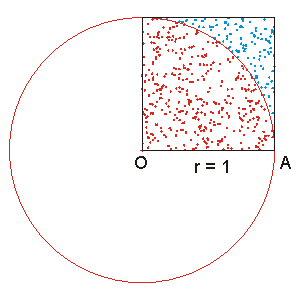

In [ ]:
import random

@jit(nopython=True)
def monte_carlo_serial(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples


@jit(nopython=True, parallel=True)
def monte_carlo_parallel(nsamples):
    acc = 0
    for i in numba.prange(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [ ]:
print(monte_carlo_parallel(10))
print(monte_carlo_parallel(100))
print(monte_carlo_parallel(1000))
print(monte_carlo_parallel(10000))

In [ ]:
%timeit monte_carlo_serial(1000000000)
%timeit monte_carlo_parallel(1000000000)

### Diccionarios

Algunas características de Python NO están soportadas en Numba, por ejemplo, el uso de diccionarios (`dic`) inicializados.

In [ ]:
@jit(nopython=True)
def no_init_dict():
    d = dict()
    d[0] = 1
    return d

@jit(nopython=True)
def init_dict():
    d = dict({0:1})
    return d

In [ ]:
no_d = no_init_dict()
print(no_d)

In [ ]:
# d = init_dict()
d = init_dict.py_func()
print(d)